# OpenMined Duet Authority

This is replicating the logic which should ideally be hosted as a full stack application. In particular the [OMAuthorityAgent.py](./src/OMAuthorityAgent.py) class has been copied and slightly edited from this full stack application. The full stack application code can be found at this repo - https://github.com/wip-abramson/fpc-om-authority-aries-application

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController

from src.OMAuthorityAgent import OMAuthorityAgent

import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://om-authority-agent:3021 and an api key of OM_Authority


### Start a Webhook Server

In [3]:
webhook_port = os.getenv("WEBHOOK_PORT")
webhook_host = "0.0.0.0"

agent_controller.init_webhook_server(webhook_host, webhook_port)

## Store Issuing Schema and Cred Def Identifiers

This is helpful as it means as long as you run `./manage stop` to stop the containers you will not need to reinitialise your agent. State will be persisted and the values you copied below will still be valid.

In [4]:
scientist_schema_id= "Sgg1wREgfEwbEPCQn9xEuE:2:OM Data Scientist:0.0.1"

### YOU WILL NEED TO REPLACE THIS VALUE WITH THE ONE OUTPUT FROM THE om_authority_init.ipynb file ###
scientist_cred_def_id = "4ZRQ85PM6omuqq4tVtRJcd:3:CL:188831:default"


scientist_config = {
    "schema_id": scientist_schema_id,
    "cred_def_id": scientist_cred_def_id
}

In [5]:
owner_schema_id= "Sgg1wREgfEwbEPCQn9xEuE:2:OM Data Owner:0.0.1"

### YOU WILL NEED TO REPLACE THIS VALUE WITH THE ONE OUTPUT FROM THE om_authority_init.ipynb file ###
owner_cred_def_id = "4ZRQ85PM6omuqq4tVtRJcd:3:CL:188835:default"

owner_config = {
    "schema_id": owner_schema_id,
    "cred_def_id": owner_cred_def_id
}

## Initialise the OMAuthority Agent

By passing in the configuration jsons for scientist and data owner you identify the schema and cred defs that class will issue to the respective actors.

In [6]:
om_authority_agent = OMAuthorityAgent(agent_controller, owner_config, scientist_config)

Subscribing too: connections
Subscribing too: present_proof
Subscribing too: issue_credential


## Optional: Authentiate Against Agent Using OM PKI Course Credential

This is used in the full stack application as a "login" before you can generate connections for the data scientist or owner. The full stack application then uses the connection_id to authenticate future api requests, only allowing them for those connections which have succesfully responded to the proof.

### First Configure the Auth Policy

This identifies the set of attributes and constraints under which a proof must be produced. The below cell identifies the OM PKI Course credential you should have issued to your mobile earlier in the course.

Note: If you have not got this credential you can skip this part. Or alternatively you could attempt to use combine the recipes to issue yourself a credential against this schema. Or if you are feeling adventurous define and issue a new schema and update the below authentication policy accordingly.

In [7]:
pki_schema_id = "Sgg1wREgfEwbEPCQn9xEuE:2:OpenMined PKI Course:0.0.1"

req_attrs = [
    {"name": "name", "restrictions": [{"schema_id": pki_schema_id}]}, 
]

indy_proof_request = {
    "name": "Proof of PKI Course",
    "version": "1.0",
    "requested_attributes": {
        # They must follow this uuid pattern
        f"0_{req_attr['name']}_uuid":
            req_attr for req_attr in req_attrs
    },
    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
    },
}

om_authority_agent.set_client_auth_policy(indy_proof_request)



### Get Client Invitation and Display as QR Code.

You will need to scan this QRCode using the mobile wallet containing a OpenMined PKI Course Credential

In [8]:
client_invite_response = om_authority_agent.client_invitation()
## URL For the invitation so it can be displayed as a QRCode
invitation_url = client_invite_response["invite_url"]
## Connection ID used by OM Authority to identify the agent that responds to this invite
client_connection_id = client_invite_response["connection_id"]
print(client_invite_response)

INFO:aiohttp.access:172.28.0.4 [21/Apr/2021:14:11:22 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  0541d09d-be7d-4cf0-a9e9-f802c26d3cad
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
{'invite_url': 'http://425e6ef2afa7.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNDMyMmQwYzEtYWQ2OC00OTgzLWExZWYtNzgyMWYyYTk4ZDU5IiwgImxhYmVsIjogIk9wZW5NaW5lZCBEdWV0IEF1dGhvcml0eSIsICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cDovLzQyNWU2ZWYyYWZhNy5uZ3Jvay5pbyIsICJyZWNpcGllbnRLZXlzIjogWyI1bm94NUo3bUZXdU51c1NLVG1zOGFQd2VDNEpzY1d3QmZLcmJ6UTg5dDZiRSJdfQ==', 'connection_id': '0541d09d-be7d-4cf0-a9e9-f802c26d3cad'}


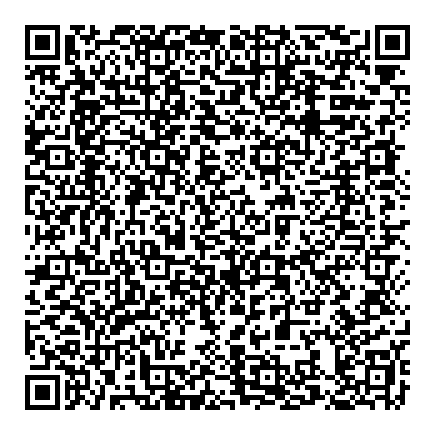

In [9]:
import qrcode
# Link for connection invitation

# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

### Check Connection ID Trusted List

This would be the connection_id used to authenticate a client application. By sending the connection_id with every api request and checking with the agent if this connection_id is "trusted" we have created a (very hacky) user authentication system.

Work is currently ongoing to use the controller the OpenID Connect protocol.

In [10]:
is_trusted = om_authority_agent.client_connection_trusted(client_connection_id)
print("Is Client Trusted? ", is_trusted)


Is Client Trusted?  False


## Issue Data Owner Credential

Before you can issue a credential you must first establish a connection across which the credential will be issued.

### What Attributes Are You Issuing

The full stack application allows an authenticated user to submit attributes in a form which are then issued as part of a DataScientist credential. 

In [7]:
domain = "Healthcare"
name = "Some Hospital"

### Create Data Owner Invitation

This invite would be returned to the frontend. Where it can then be shared with the Data Owner by copying across to the relevant notebook. 

Once the invitation has been accepted and becomes active, the OM Authority agent will automatically issue a Data Owner credential with the attributes passed to it when the invitation was created. See `src/OMAuthorityAgent.py` for the code.

In [8]:
invitation = om_authority_agent.data_owner_invitation(name, domain)
## Copy this to the Data Owner notebook
print(invitation)

INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:35:57 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  817564e4-4000-41c9-96bf-258f4d765240
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '86165e42-d747-4047-9e12-ddf8f5007ffd', 'label': 'OpenMined Duet Authority', 'recipientKeys': ['5EgPHwkJwFqzJaYG8QVhDieT7gVz1RXntCfYimLbMKtK'], 'serviceEndpoint': 'https://d67c71672916.ngrok.io'}


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:13 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"
INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:13 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  817564e4-4000-41c9-96bf-258f4d765240
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  817564e4-4000-41c9-96bf-258f4d765240
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


INFO:root:issuing data scientist - 817564e4-4000-41c9-96bf-258f4d765240 a credential using schema Sgg1wREgfEwbEPCQn9xEuE:2:OM Data Owner:0.0.1 and definition 4ZRQ85PM6omuqq4tVtRJcd:3:CL:188835:default


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  817564e4-4000-41c9-96bf-258f4d765240
State :  active
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:14 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"
INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:14 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 817564e4-4000-41c9-96bf-258f4d765240
Credential exchange ID : be26d2b5-86e7-4f17-be50-99206c71ce0a
Agent Protocol Role :  issuer
Protocol State :  offer_sent

---------------------------------------------------

Offering credential with attributes  : [{'name': 'name', 'value': 'Some Hospital'}, {'name': 'domain', 'value': 'Healthcare'}]


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:15 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"
INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:15 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 817564e4-4000-41c9-96bf-258f4d765240
Credential exchange ID : be26d2b5-86e7-4f17-be50-99206c71ce0a
Agent Protocol Role :  issuer
Protocol State :  request_received

---------------------------------------------------

Request for credential received

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 817564e4-4000-41c9-96bf-258f4d765240
Credential exchange ID : be26d2b5-86e7-4f17-be50-99206c71ce0a
Agent Protocol Role :  issuer
Protocol State :  credential_issued

---------------------------------------------------



INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:15 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 817564e4-4000-41c9-96bf-258f4d765240
Credential exchange ID : be26d2b5-86e7-4f17-be50-99206c71ce0a
Agent Protocol Role :  issuer
Protocol State :  credential_acked

---------------------------------------------------



## Issue Data Scientist Credential

### What Attributes Are You Issuing

The full stack application allows an authenticated user to submit attributes in a form which are then issued as part of a DataScientist credential. 

In [9]:
scope = "Healthcare"
name = "Some Healthcare Research Org"

### Create Data Scientist Invitation

This invite would be returned to the frontend. Where it can then be shared with the Data Scientist by copying across to the relevant notebook. 

Once the invitation has been accepted and becomes active, the OM Authority agent will automatically issue a Data Scientist credential with the attributes passed to it when the invitation was created. See `src/OMAuthorityAgent.py` for the code.

In [10]:
invitation = om_authority_agent.data_scientist_invitation(name, scope)
## Copy this to the Data Scientist notebook
print(invitation)

INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:29 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  afcccb28-8654-4ef7-9ace-276bfb81769c
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'e2690b2e-d25a-4783-a349-763ab3276004', 'label': 'OpenMined Duet Authority', 'recipientKeys': ['79UeKfvYabjXPgqPryYsQA65xJkG2tQUDEF3tMvYTJcx'], 'serviceEndpoint': 'https://d67c71672916.ngrok.io'}


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:51 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"
INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:51 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  afcccb28-8654-4ef7-9ace-276bfb81769c
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  afcccb28-8654-4ef7-9ace-276bfb81769c
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


INFO:root:issuing data scientist - afcccb28-8654-4ef7-9ace-276bfb81769c a credential using schema Sgg1wREgfEwbEPCQn9xEuE:2:OM Data Scientist:0.0.1 and definition 4ZRQ85PM6omuqq4tVtRJcd:3:CL:188831:default


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  afcccb28-8654-4ef7-9ace-276bfb81769c
State :  active
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:52 +0000] "POST /topic/connections/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"
INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:52 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : afcccb28-8654-4ef7-9ace-276bfb81769c
Credential exchange ID : 97a3283f-4093-4cc5-b388-f6281aa8da98
Agent Protocol Role :  issuer
Protocol State :  offer_sent

---------------------------------------------------

Offering credential with attributes  : [{'name': 'name', 'value': 'Some Healthcare Research Org'}, {'name': 'scope', 'value': 'Healthcare'}]


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:53 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : afcccb28-8654-4ef7-9ace-276bfb81769c
Credential exchange ID : 97a3283f-4093-4cc5-b388-f6281aa8da98
Agent Protocol Role :  issuer
Protocol State :  request_received

---------------------------------------------------

Request for credential received


INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:53 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : afcccb28-8654-4ef7-9ace-276bfb81769c
Credential exchange ID : 97a3283f-4093-4cc5-b388-f6281aa8da98
Agent Protocol Role :  issuer
Protocol State :  credential_issued

---------------------------------------------------



INFO:aiohttp.access:192.168.112.4 [21/Apr/2021:14:36:54 +0000] "POST /topic/issue_credential/ HTTP/1.1" 200 155 "-" "Python/3.6 aiohttp/3.6.3"



---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : afcccb28-8654-4ef7-9ace-276bfb81769c
Credential exchange ID : 97a3283f-4093-4cc5-b388-f6281aa8da98
Agent Protocol Role :  issuer
Protocol State :  credential_acked

---------------------------------------------------



## Congratulations. Both the DataScientist and DataOwner "notebook applications" should now have the necessary credentials to authenticate each other before establishing a Duet session.

Be sure to check out the [full stack application for this notebook](https://github.com/wip-abramson/fpc-om-authority-aries-application). Hopefully it is hosted somewhere so you can get a feel for what that user experience might be like. 

Much much more work to be done on that front though!

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [ ]:
await agent_controller.terminate()